In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cmocean.cm as cm
from scipy.interpolate import LinearNDInterpolator

%matplotlib inline

In [3]:
res = 50
tres = 48
u,v = np.zeros([tres,res,res]),np.zeros([tres,res,res])

for t in range(tres):
    for j in range(res):
        for i in range(res):
            u[t,:,:] = np.sin(float(t/tres)*2.*np.pi) + 0.5*np.cos((j/res)*2.*np.pi) + 0.25*np.sin((i/res)*2.*np.pi) + 0.1
            v[t,:,:] = np.cos(float(t/tres)*2.*np.pi) + 0.5*np.sin((i/res)*2.*np.pi) + 0.25*np.cos((j/res)*2.*np.pi) + 0.2

In [4]:
tgrid,jgrid,igrid = np.zeros_like(u),np.zeros_like(u),np.zeros_like(u)
for t in range(tres):
    tgrid[t,:,:] = t
for j in range(res):
    jgrid[:,j,:] = j
for i in range(res):
    igrid[:,:,i] = i
    
uint = LinearNDInterpolator((tgrid.ravel(),jgrid.ravel(),igrid.ravel()),u.ravel())
vint = LinearNDInterpolator((tgrid.ravel(),jgrid.ravel(),igrid.ravel()),v.ravel())

In [5]:
x0 = 0.; y0 = 0.
T = 100.
dt = 0.5

In [6]:
t = 0
xa = np.array([x0,]); x = x0
ya = np.array([y0,]); y = y0
while t < T:
    k1x = uint(t,y,x)
    k1y = vint(t,y,x)
    k2x = uint(t + 0.5*dt,y + 0.5*k1y*dt,x + 0.5*k1x*dt)
    k2y = vint(t + 0.5*dt,y + 0.5*k1y*dt,x + 0.5*k1x*dt)
    k3x = uint(t + 0.5*dt,y + 0.5*k2y*dt,x + 0.5*k2x*dt)
    k3y = vint(t + 0.5*dt,y + 0.5*k2y*dt,x + 0.5*k2x*dt)
    k4x = uint(t + dt,y + k3y*dt,x + k3x*dt)
    k4y = vint(t + dt,y + k3y*dt,x + k3x*dt)
    x += (1./6.)*(k1x + 2.*k2x + 2.*k3x + k4x)*dt; xa = np.hstack([xa,x])
    y += (1./6.)*(k1y + 2.*k2y + 2.*k3y + k4y)*dt; ya = np.hstack([ya,y])
    t += dt
    if t % 10. == 0.:
        print(t)

10.0
20.0
30.0
40.0
50.0
60.0
70.0
80.0
90.0
100.0


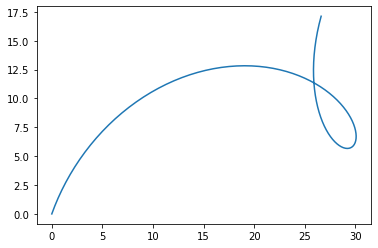

In [7]:
plt.plot(xa,ya)

In [8]:
res = 200
tres = 48
u,v = np.zeros([tres,res,res]),np.zeros([tres,res,res])

for t in range(tres):
    for j in range(res):
        for i in range(res):
            u[t,j,i] = np.sin(float(t/tres)*2.*np.pi) + 0.5*np.cos((j/res)*2.*np.pi) + 0.25*np.sin((i/res)*2.*np.pi) + 0.2
            v[t,j,i] = np.cos(float(t/tres)*2.*np.pi) + 0.5*np.sin((i/res)*2.*np.pi) + 0.25*np.cos((j/res)*2.*np.pi) + 0.1

In [ ]:
x0,y0 = (3,3)
dt = 1
T = tres

N = 2
uoff = np.linspace(-0.1,0.2,N)
voff = np.linspace(-0.05,0.1,N)

tbuff = 2
t = 0
pos = np.complex(y0,x0)
buff = 3

tslice = slice(np.min([0,t-tbuff]),t+tbuff+1)
dgridj,dgridi = np.meshgrid(np.arange(res),np.arange(res))
d = np.sqrt((dgridj - pos.real)**2. + (dgridi - pos.imag)**2.)
cj,ci = np.where(d == d.min()); cj,ci = cj[0],ci[0]
jslice = slice(cj-buff,cj+buff)
islice = slice(ci - buff,ci + buff)

velfuzz = np.zeros([tslice.stop - tslice.start,jslice.stop - jslice.start,islice.stop - islice.start,N**2]).astype(complex)
for t in range(tslice.start,tslice.stop):
    for j in range(jslice.start,jslice.stop):
        for i in range(islice.start,islice.stop):
            Ncount = 0
            for mu in range(N):
                for mv in range(N):
                    velfuzz[t,j,i,Ncount] = np.complex(u[t,j,i] + uoff[mu],v[t,j,i] + voff[mv])
                    Ncount += 1

tgrid,jgrid,igrid,Ngrid = np.zeros_like(velfuzz.real),np.zeros_like(velfuzz.real),np.zeros_like(velfuzz.real),np.zeros_like(velfuzz.real)
for t in range(velfuzz.shape[0]):
    tgrid[t,:,:,:] = t
for j in range(velfuzz.shape[1]):
    jgrid[:,j,:,:] = j
for i in range(velfuzz.shape[2]):
    igrid[:,:,i,:] = i
for n in range(velfuzz.shape[3]):
    Ngrid[:,:,:,n] = n

In [ ]:
velint = LinearNDInterpolator((tgrid.ravel(),jgrid.ravel(),igrid.ravel(),Ngrid.ravel()),velfuzz.ravel())

In [ ]:
t = 0
k1 = velint(t,pos.real,pos.imag,np.arange(Ncount))
k2 = np.array([velint(t + dt/2.,pos.real + k1.real*dt/2.,pos.imag + k1.imag*dt/2.,n) for n in range(Ncount)])
k3 = np.array([velint(t + dt/2.,pos.real + k2.real*dt/2.,pos.imag + k2.imag*dt/2.,n) for n in range(Ncount)])
k4 = np.array([velint(t + dt,pos.real + k3.real*dt,pos.imag + k3.imag*dt,n) for n in range(Ncount)])

In [ ]:
#pos(t+dt) = pos + (1/6)(k1+2k2+2k3+k4)dt
#express k1,k2,k3,k4 as fuzzy numbers to calculate this using interval analysis (no k appears twice)
lu = (k1.real.min() + 2.*k2.real.min() + 2.*k3.real.min() + k4.real.min()) / 6.
uu = (k1.real.max() + 2.*k2.real.max() + 2.*k3.real.max() + k4.real.max()) / 6.
lv = (k1.imag.min() + 2.*k2.imag.min() + 2.*k3.imag.min() + k4.imag.min()) / 6.
uv = (k1.imag.max() + 2.*k2.imag.max() + 2.*k3.imag.max() + k4.imag.max()) / 6.

x = (pos.real + lu*dt,pos.real + uu*dt)
y = (pos.imag + lv*dt,pos.imag + uv*dt)

print(x)
print(y)

plt.scatter(pos.real,pos.imag,color='r',zorder=1001)
plt.scatter(x[0],y[0],color='0.8',zorder=1000)
plt.scatter(x[0],y[1],color='0.8',zorder=1000)
plt.scatter(x[1],y[1],color='0.8',zorder=1000)
plt.scatter(x[1],y[0],color='0.8',zorder=1000)

**Solution Strategy**

1. Get fuzzy correction factors for current, wind, and Stokes drift

    a. Observed currents/winds have uncertainty from unresolved time scales and instrument uncertainty
    
    b. modelled currents/winds have uncertainty from interpolation and unresolved time scales
    
    c. Derive fuzzy observations and model results and subtract to get correction factor
    
    d. estimate maximum acceleration from currents and winds based on the observation record for later use
    
    e. base Stokes drift on wave period and wind direction
    
2. Apply fuzzy correction factors to modelled current, wind, and Stokes drift fields for time period of interest and combine into fuzzy drift velocity field

3. Interpolate drift velocity to starting position

4. Discretize each alpha level into a number of starting positions corresponding to intervals with a width of twice the maximum acceleration due to combined current and wind; start a particle at the center of each interval

5. Integrate using RK4 solver with max. acc. interval as uoff, voff plus modelled velocity change as the uncertainty interval; similar to obs paper

6. at each time step, define area occupied by new particle positions and start a fixed number of particles evenly distributed through this area

In [ ]:
t = 0

plt.scatter(pos.real,pos.imag,color='r',zorder=1001)

for n in range(Ncount):
    k1 = velint(t,pos.real,pos.imag,n)
    k2 = velint(t + dt/2.,pos.real + k1.real*dt/2.,pos.imag + k1.imag*dt/2.,n)
    k3 = velint(t + dt/2.,pos.real + k2.real*dt/2.,pos.imag + k2.imag*dt/2.,n)
    k4 = velint(t + dt,pos.real + k3.real*dt,pos.imag + k3.imag*dt,n)
    
    x = pos.real + (1./6.)*(k1.real+2.*k2.real+2.*k3.real+k4.real)*dt
    y = pos.imag + (1./6.)*(k1.imag+2.*k2.imag+2.*k3.imag+k4.imag)*dt
    plt.scatter(x,y,color='0.8',zorder=1000)

In [2]:
import netCDF4 as nc
import datetime
from scipy.spatial import ConvexHull
from pyproj import Proj
proj = Proj("+proj=utm +zone=10U, +north +ellps=WGS84 +datum=WGS84 +units=m +no_defs")

In [3]:
fu = 'C:/Users/Blankenh/Documents/Documents/UVic/Thesis/SSC_Out/Model_U.nc'
fv = 'C:/Users/Blankenh/Documents/Documents/UVic/Thesis/SSC_Out/Model_V.nc'
fatm = 'C:/Users/Blankenh/Documents/Documents/UVic/Thesis/SSC_Out/Model_Wind.nc'
fgO = 'C:/Users/Blankenh/Documents/Documents/UVic/Thesis/SSC_Out/ubcSSnBathymetryV17-02_a29d_efc9_4047.nc'
fgA = 'C:/Users/Blankenh/Documents/Documents/UVic/Thesis/SSC_Out/Wind_MeshMask.nc'

with nc.Dataset(fu) as data:
    uO = data['uVelocity'][:,0,:,:]
    timeO = np.array([datetime.datetime(t.year,t.month,t.day,t.hour,t.minute,t.second) for t in nc.num2date(data['time'][:],data['time'].units)])
    
with nc.Dataset(fv) as data:
    vO = data['vVelocity'][:,0,:,:]
    
ang = 29. * np.pi/180.
u = np.cos(ang) * uO + np.sin(ang) * vO
v = np.cos(ang) * vO - np.sin(ang) * uO

u = (u[:,:,:-1] + u[:,:,1:]) / 2.; u = u[:,1:,:]
v = (v[:,:-1,:] + v[:,1:,:]) / 2.; v = v[:,:,1:]

with nc.Dataset(fgO) as data:
    lon = data['longitude'][1:,1:]
    lat = data['latitude'][1:,1:]
    
x,y = proj(lon,lat)

In [110]:
speed_radius = 500. #meters
slice_time = 600.   #seconds

N = 3
uoff = np.linspace(-0.2,0.1,N)
voff = np.linspace(-0.1,0.1,N)

npoints = 100

start_pos = (-123.179,48.332)
proj_pos = proj(start_pos[0],start_pos[1])
xy = [[[proj_pos[0],proj_pos[1]]]]

start_time = datetime.datetime(2017,10,6,8,0,0)
end_time = datetime.datetime(2017,10,6,12,0,0)
dt = 60.

time = start_time
new_slice = True
count_slice_time = 0.

while time < end_time:
    count_slice_time += dt
    if count_slice_time >= slice_time:
        count_slice_time = 0.
        new_slice = True
        
    if new_slice:
        d = np.array([np.sqrt((x - xy1[0])**2. + (y - xy1[1])**2.) for xy1 in xy[-1]]).min(axis=0)
        assumed_max_speed = np.sqrt(u[:,d <= speed_radius]**2. + v[:,d <= speed_radius]**2.).max()
        jslice,islice = np.where(d <= assumed_max_speed * slice_time)

        time_start_ind = np.where(timeO  <= time)[0][-1]
        time_end_ind = np.where(timeO >= time + datetime.timedelta(seconds=slice_time))[0][0]
        tslice = slice(time_start_ind,time_end_ind+1)

        velfuzz = np.zeros([tslice.stop - tslice.start,len(jslice),len(islice),N**2]).astype(complex)
        for t1,t2 in enumerate(range(tslice.start,tslice.stop)):
            for j1,j in enumerate(jslice):
                for i1,i in enumerate(islice):
                    Ncount = 0
                    for mu in range(N):
                        for mv in range(N):
                            velfuzz[t1,j1,i1,Ncount] = np.complex(u[t2,j,i] + uoff[mu],v[t2,j,i] + voff[mv])
                            Ncount += 1

        tgrid,Ngrid = np.zeros_like(velfuzz.real),np.zeros_like(velfuzz.real)
        igrid,jgrid = np.zeros_like(velfuzz.real),np.zeros_like(velfuzz.real)
        dts = np.array([(t2 - timeO[tslice][0]).total_seconds() for t2 in timeO[tslice]])
        for t1,t2 in enumerate(dts):
            tgrid[t1,:,:,:] = t2
        for n in range(N**2):
            Ngrid[:,:,:,n] = n
            for t2 in range(len(dts)):
                jgrid[t2,:,:,n] = y[jslice,islice]
                igrid[t2,:,:,n] = x[jslice,islice]

        velint = LinearNDInterpolator((tgrid.ravel(),jgrid.ravel(),igrid.ravel(),Ngrid.ravel()),
                                      velfuzz.ravel(),rescale=True)
        new_slice = False

    t = (time - timeO[tslice][0]).total_seconds()
    pos_list = []
    for xy1 in xy[-1]:
        pos = np.complex(xy1[1],xy1[0])

        k1 = velint(t,pos.real,pos.imag,np.arange(Ncount))
        k2 = np.array([velint(t + dt/2.,pos.real + k1.real*dt/2.,pos.imag + k1.imag*dt/2.,n) for n in range(Ncount)])
        k3 = np.array([velint(t + dt/2.,pos.real + k2.real*dt/2.,pos.imag + k2.imag*dt/2.,n) for n in range(Ncount)])
        k4 = np.array([velint(t + dt,pos.real + k3.real*dt,pos.imag + k3.imag*dt,n) for n in range(Ncount)])
        
        for k in [k1,k2,k3,k4]:
            if np.isnan(k).any():
                print('NaN\'s in interpolator, increase the buffer size')
            
        lu = (k1.real.min() + 2.*k2.real.min() + 2.*k3.real.min() + k4.real.min()) / 6.
        uu = (k1.real.max() + 2.*k2.real.max() + 2.*k3.real.max() + k4.real.max()) / 6.
        lv = (k1.imag.min() + 2.*k2.imag.min() + 2.*k3.imag.min() + k4.imag.min()) / 6.
        uv = (k1.imag.max() + 2.*k2.imag.max() + 2.*k3.imag.max() + k4.imag.max()) / 6.

        xp = (pos.imag + lu*dt,pos.imag + uu*dt)
        yp = (pos.real + lv*dt,pos.real + uv*dt)
    
        pos_list += [[xp[0],yp[0]],[xp[0],yp[1]],[xp[1],yp[1]],[xp[1],yp[0]]]
        
    pos_lista = np.asarray(pos_list)
    hull = ConvexHull(pos_lista)
    vertices = pos_lista[hull.vertices,:]; vertices = np.vstack([vertices,vertices[0,:]])
    arr = np.zeros([vertices.shape[0],3])
    for i in range(vertices.shape[0]):
        arr[i,0] = i
        arr[i,1:] = vertices[i,:]
    interp_points = np.linspace(arr[:,0].min(),arr[:,0].max(),npoints)
    vertices_interp = np.column_stack([np.interp(interp_points,arr[:,0],arr[:,1]),
                                       np.interp(interp_points,arr[:,0],arr[:,2])]).tolist()
    xy.append(vertices_interp)
    time += datetime.timedelta(seconds=dt)
    if time.minute % 10. == 0:
        print(time)

2017-10-06 08:10:00
2017-10-06 08:20:00
2017-10-06 08:30:00
2017-10-06 08:40:00
2017-10-06 08:50:00
2017-10-06 09:00:00
2017-10-06 09:10:00
2017-10-06 09:20:00
2017-10-06 09:30:00
2017-10-06 09:40:00
2017-10-06 09:50:00
2017-10-06 10:00:00
2017-10-06 10:10:00
2017-10-06 10:20:00
2017-10-06 10:30:00
2017-10-06 10:40:00
2017-10-06 10:50:00
2017-10-06 11:00:00
2017-10-06 11:10:00
2017-10-06 11:20:00
2017-10-06 11:30:00
2017-10-06 11:40:00
2017-10-06 11:50:00
2017-10-06 12:00:00


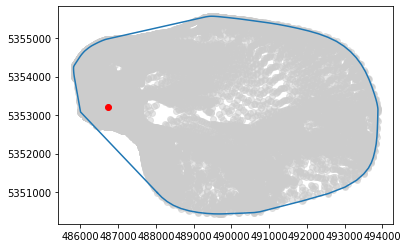

In [111]:
plt.scatter(xy[0][0][0],xy[0][0][1],color='r',zorder=1002)
pts = []
for xy1 in xy:
    for xy3 in xy1:
        pts.append([xy3[0],xy3[1]])
        
ptsa = np.asarray(pts)
hull = ConvexHull(ptsa)
vertices = ptsa[hull.vertices,:]; vertices = np.vstack([vertices,vertices[0,:]])
plt.scatter(ptsa[:,0],ptsa[:,1],color='0.8',alpha=0.5,zorder=1000)
plt.plot(vertices[:,0],vertices[:,1],zorder=1001)